In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
SMALL_SIZE = 24
MEDIUM_SIZE = 30
BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



from timeit import default_timer
from Solver import *
from functools import partial

import torch

import sys
sys.path.append('../Utility')
from Numerics import gradient_first,  gradient_first_c2f, gradient_first_f2c, interpolate_c2f, interpolate_f2c, psi_fft_sol, gradient_fft
import NeuralNet



In [3]:
Ny = 256
L = 50*2*np.pi
H = [1.0, 1.0]               # the rest depths of each layer
kd = 1.0                     # rd
beta = 3.0
mu = 0.3                     # bottom drag rek
U = [0.0, 0.0]
dU = U[0] - U[1] 
F1 = kd/(1 + (H[0]/H[1])**2.0)
F2 = kd/(1 + (H[1]/H[0])**2.0)
beta1, beta2 = beta + F1*dU, beta - F2*dU
hyper_nu, hyper_order = 0.0, 2
Q = 1.0

yy, dy = np.linspace(L/(2*Ny), L - L/(2*Ny), Ny), L/Ny

force = np.zeros((2, Ny))
force[0, :] = -Q * np.sin(2*np.pi*yy/L)
force[1, :] =  Q * np.sin(2*np.pi*yy/L)

In [4]:
betas = [1, 2, 3]

folder_names = ["/central/groups/esm/dzhuang/pyqg_run/2layer/nx256beta" + str(betas[i]) + "rek0p3/" for i in range(len(betas))]
file_names = ["nx256beta" + str(betas[i]) + "rek0p3" for i in range(len(betas))] 

start, end, step = 500000, 1000000, 20000

N_data = len(folder_names)
mu_mean,  closure_mean,  dpv_mean, q_mean, psi_mean = np.zeros((N_data, 2, Ny)), np.zeros((N_data, 2, Ny)), np.zeros((N_data, 2, Ny)), np.zeros((N_data, 2, Ny)), np.zeros((N_data, 2, Ny))


for i in range(N_data):  
    
    flow_means, flow_zonal_means = preprocess_data(folder_names[i], file_names[i], betas[i], dU, L, start, end, step)
    mu_mean[i, :, :], dpv_mean[i, :, :], u_mean, vor_mean, q_mean[i, :, :], psi_mean[i, :, :], closure_mean[i, :, :], psi_var_2_mean = flow_means[:8]


In [5]:
# TODO: clean data
mu_mean[mu_mean <= 0.0 ] = 0.0
for i in range(N_data):
    for layer in range(2):
        mu_mean[i, layer, :] = scipy.ndimage.gaussian_filter1d(mu_mean[i, layer, :], 5)
        

In [6]:
# Visualize data

Text(0.5, 0.98, 'bottom layer')

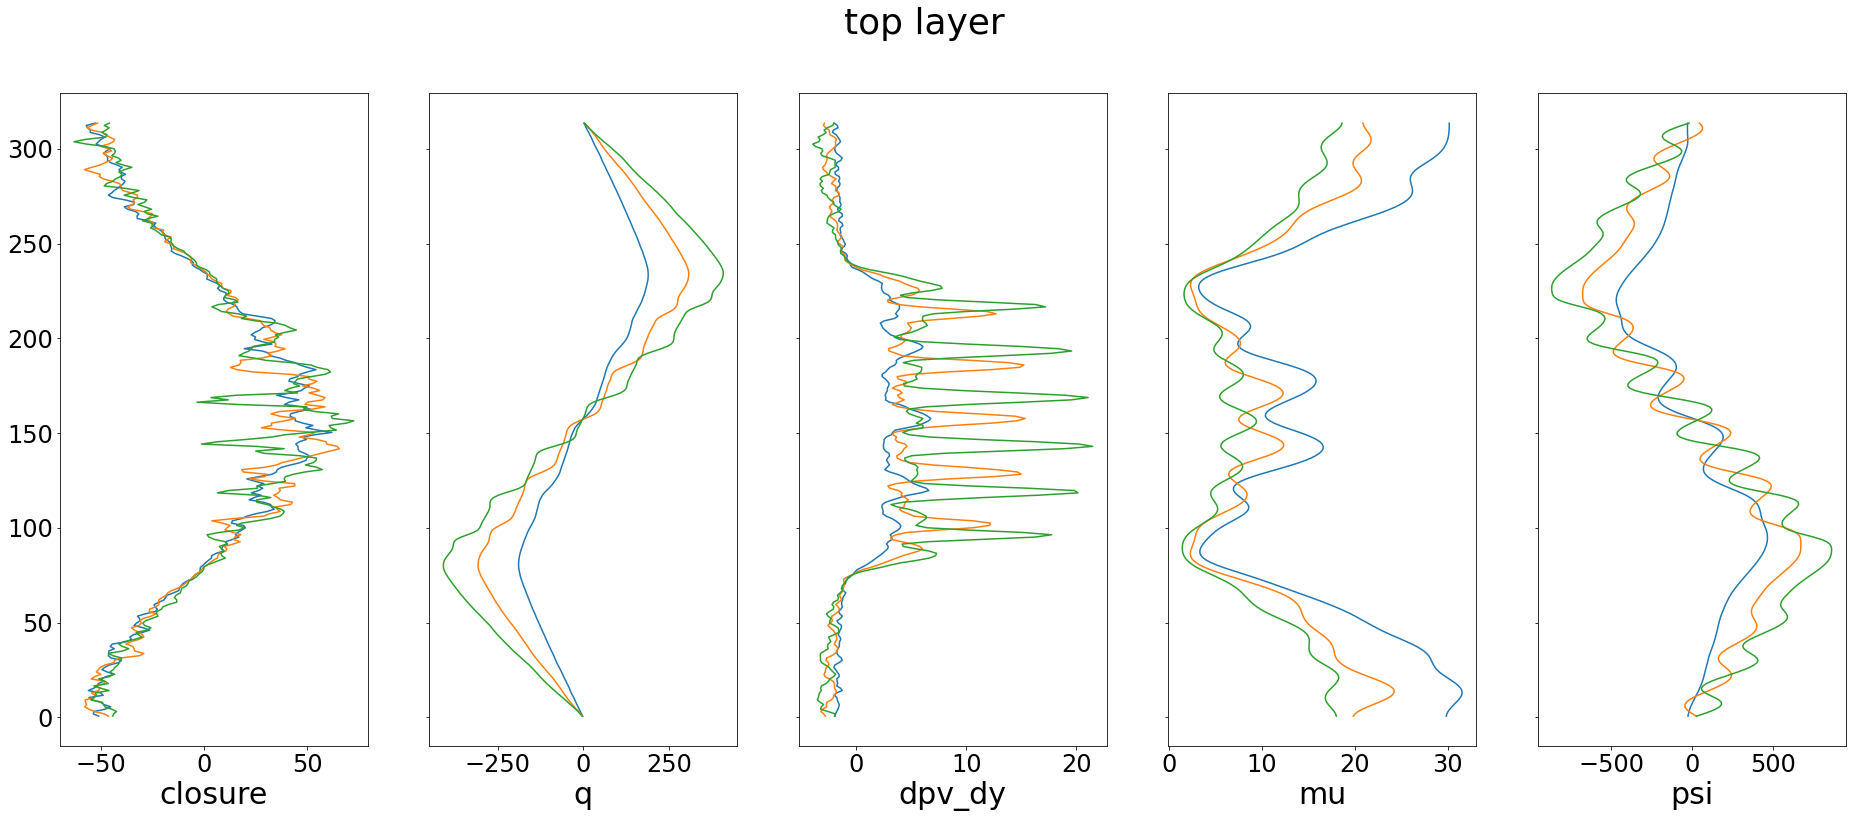

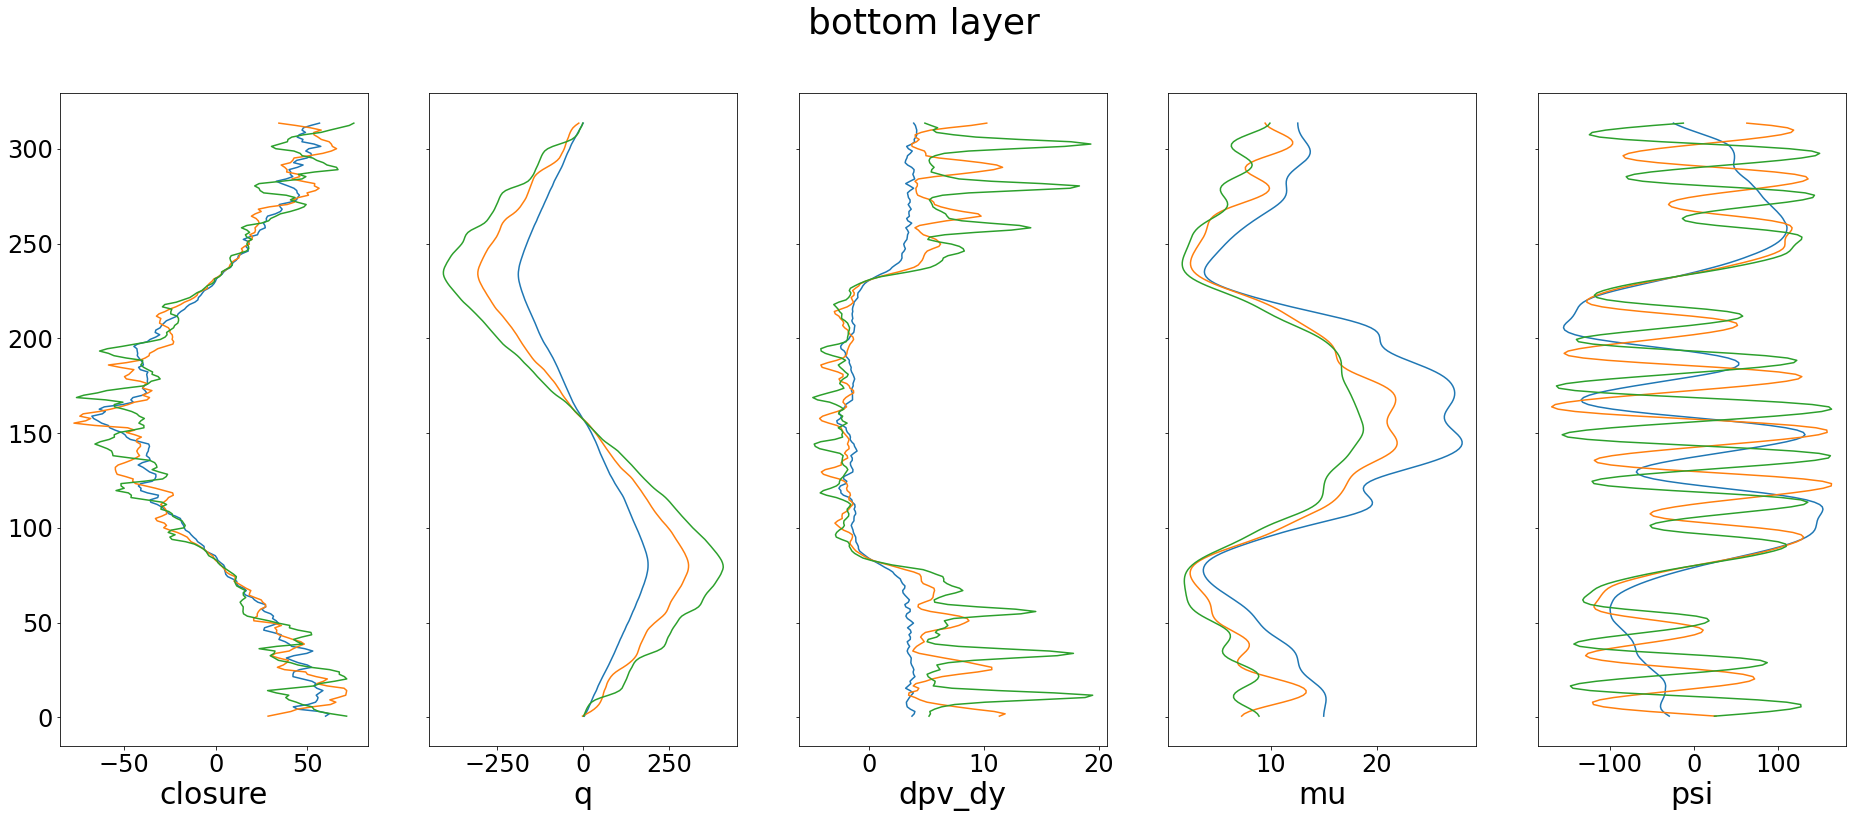

In [7]:
layer = 0
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,layer, :], yy)
    ax[1].plot(q_mean[i,layer, :], yy)
    ax[2].plot(dpv_mean[i,layer, :], yy)
    ax[3].plot(mu_mean[i,layer, :], yy)
    ax[4].plot(psi_mean[i,layer, :], yy)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dpv_dy")
    ax[3].set_xlabel("mu")
    ax[4].set_xlabel("psi")
fig.suptitle("top layer")

layer = 1
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,layer, :], yy)
    ax[1].plot(q_mean[i,layer, :], yy)
    ax[2].plot(dpv_mean[i,layer, :], yy)
    ax[3].plot(mu_mean[i,layer, :], yy)
    ax[4].plot(psi_mean[i,layer, :], yy)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dpv_dy")
    ax[3].set_xlabel("mu")
    ax[4].set_xlabel("psi")
fig.suptitle("bottom layer")

In [8]:
mu_scale = 10.0
q_scale = 100
dpv_scale = 10
nn_save_name = "visc.model"
x_train = torch.from_numpy(np.stack((np.fabs(q_mean).flatten()/q_scale, dpv_mean.flatten()/dpv_scale)).T.astype(np.float32)) 
y_train = torch.from_numpy(mu_mean.flatten()[:,np.newaxis].astype(np.float32)) / mu_scale



ind = x_train.shape[1]
outd = y_train.shape[1] 

learning_rate = 0.001
step_size = 100
gamma = 0.5  
epochs = 10000
batch_size = 64

layers = 2
width  = 20
activation='sigmoid'
initializer='default'
outputlayer='None'

net = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer) 

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

optimizer = NeuralNet.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = torch.nn.MSELoss(reduction='sum')
t0 = default_timer()
for ep in range(epochs):
    net.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:

        optimizer.zero_grad()
        out = net(x)
        
        loss = myloss(out , y)*100
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

#     scheduler.step()

    if ep % 100 == 0:
        # train_l2/= ntrain
        t2 = default_timer()
        print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
        if nn_save_name is not None:
            torch.save(net, nn_save_name)
        


Epoch :  0  Epoch time :  0.24112677411176264  Train L2 Loss :  119482.11889648438
Epoch :  100  Epoch time :  0.02998315612785518  Train L2 Loss :  15607.22592163086
Epoch :  200  Epoch time :  0.028673713095486164  Train L2 Loss :  13427.663879394531
Epoch :  300  Epoch time :  0.030561537016183138  Train L2 Loss :  12126.020324707031
Epoch :  400  Epoch time :  0.030514853075146675  Train L2 Loss :  10994.073150634766
Epoch :  500  Epoch time :  0.03049626387655735  Train L2 Loss :  9504.775695800781
Epoch :  600  Epoch time :  0.02859613811597228  Train L2 Loss :  7969.062545776367
Epoch :  700  Epoch time :  0.030116581823676825  Train L2 Loss :  6728.594253540039
Epoch :  800  Epoch time :  0.02855588705278933  Train L2 Loss :  5986.96955871582
Epoch :  900  Epoch time :  0.02863394794985652  Train L2 Loss :  5688.057067871094
Epoch :  1000  Epoch time :  0.02890498493798077  Train L2 Loss :  5483.267959594727
Epoch :  1100  Epoch time :  0.025148317916318774  Train L2 Loss :  53

# Diret test

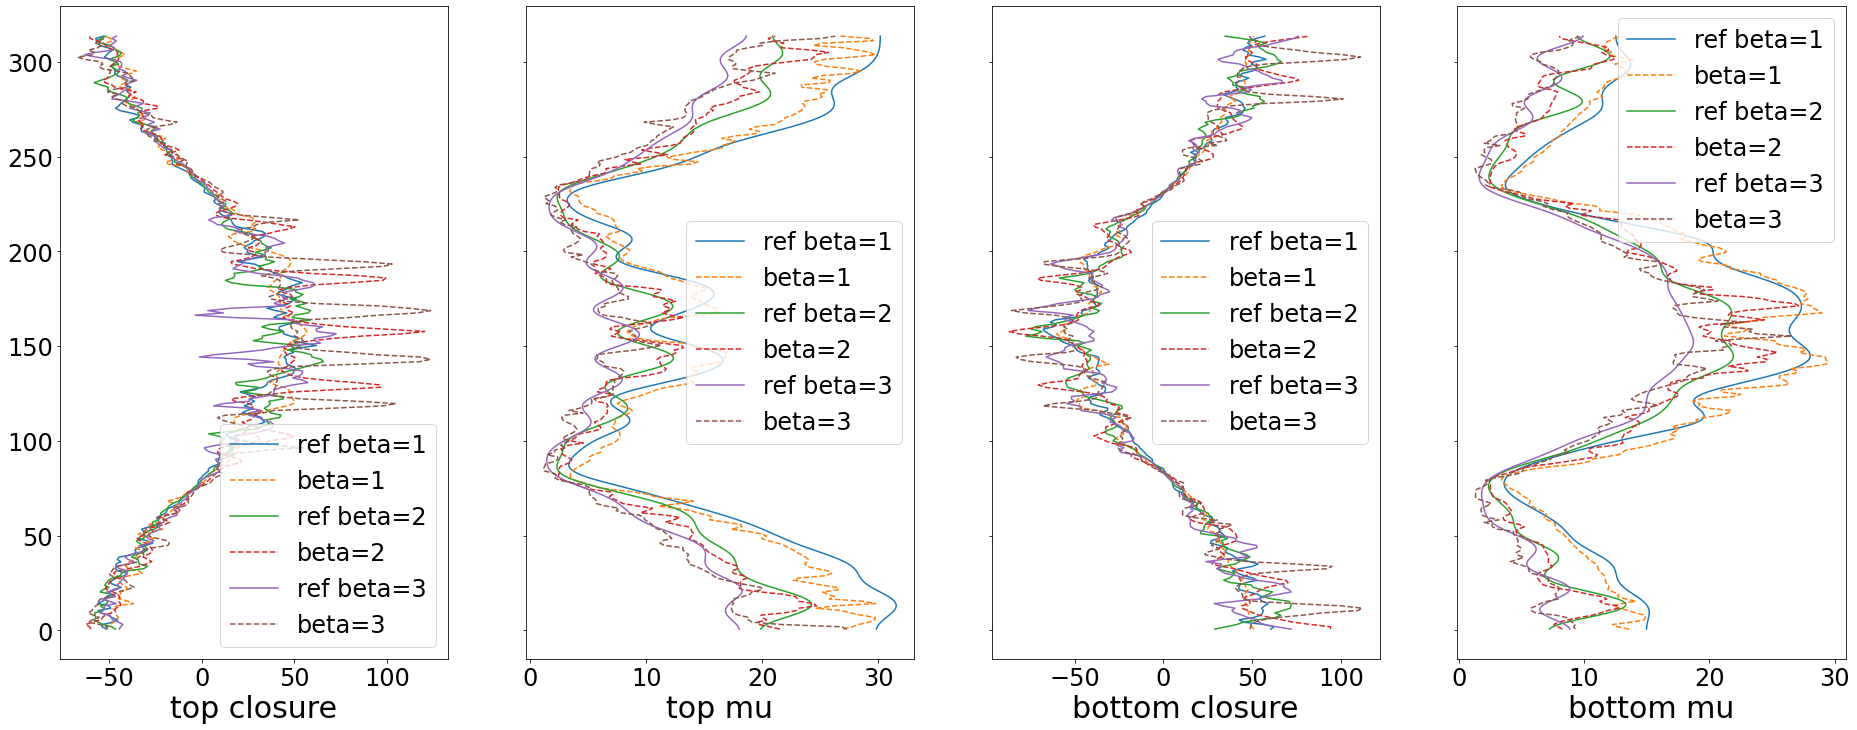

In [9]:
mu_pred = net(x_train).detach().numpy().reshape((len(betas), 2, Ny)) *  mu_scale



fig, ax = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,0, :], yy, "-", label="ref beta="+str(betas[i]))
    ax[1].plot(mu_mean[i,0, :], yy, "-", label="ref beta="+str(betas[i]))
    ax[2].plot(closure_mean[i,1, :], yy, "-", label="ref beta="+str(betas[i]))
    ax[3].plot(mu_mean[i,1, :], yy, "-", label="ref beta="+str(betas[i]))
    
    
    ax[0].plot(mu_pred[i,0, :]*dpv_mean[i,0, :], yy, "--", label="beta="+str(betas[i]))
    ax[1].plot(mu_pred[i,0, :], yy, "--", label="beta="+str(betas[i]))
    ax[2].plot(mu_pred[i,1, :]*dpv_mean[i,1, :], yy, "--", label="beta="+str(betas[i]))
    ax[3].plot(mu_pred[i,1, :], yy, "--", label="beta="+str(betas[i]))
    
    
    
    
ax[0].set_xlabel("top closure")
ax[1].set_xlabel("top mu")
ax[2].set_xlabel("bottom closure")
ax[3].set_xlabel("bottom mu")

for i in range(4):
    ax[i].legend()


In [10]:
# 'beta12rek0p32'

# file_names = ['beta12rek0p32', 'beta12rek0p64', 'beta12rek1p28', 
#               'beta16rek0p32', 'beta16rek0p64', 'beta16rek1p28'] 
# betas = [12, 12, 12, 16, 16, 16]

file_names = ['beta12rek0p32'] 
betas = [12]

n_exp = len(betas)
nx = ny = 256
n_feature = 1
ntrain = nx*n_exp
x_train_top = np.zeros((ntrain, n_feature))
x_train_bot = np.zeros((ntrain, n_feature))
y_train_top = np.zeros((ntrain, 1))
y_train_bot = np.zeros((ntrain, 1))
start, end, step = 3000000, 6000000, 20000




for i in range(n_exp):
    file_name, beta = file_names[i], betas[i]

    flow_means, _ = preprocess_data(file_name, beta, lam, dU, L, start, end, step)
    mu_mean, dpv_mean, u_mean, vor_mean, q_mean, psi_mean, flux_mean = flow_means[:7]

    x_train_top[i*nx:(i+1)*nx, 0] = dpv_mean[0, :]
    x_train_bot[i*nx:(i+1)*nx, 0] = dpv_mean[1, :]
    y_train_top[i*nx:(i+1)*nx, 0] = mu_mean[0, :]
    y_train_bot[i*nx:(i+1)*nx, 0] = mu_mean[1, :]
    


NameError: name 'lam' is not defined

# Scatter data

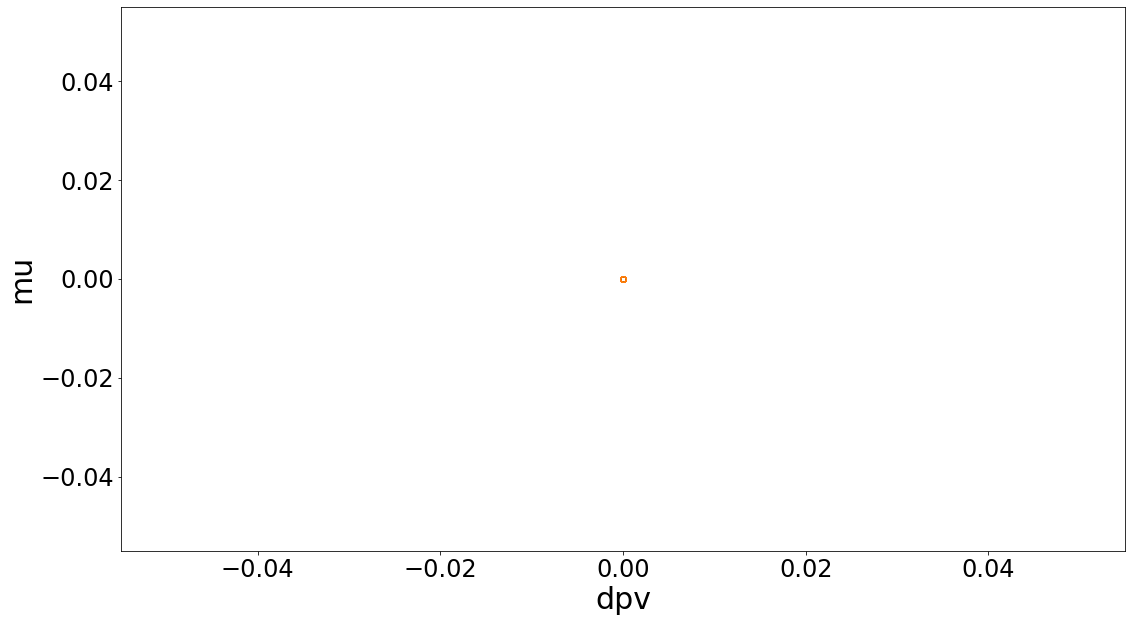

In [11]:
fig, ax = plt.subplots(1,figsize=(18,10))
for i in range(n_exp):
    ax.plot(x_train_top,  y_train_top, "o", fillstyle = "none")
    ax.plot(x_train_bot,  y_train_bot, "o", fillstyle = "none")
    ax.set_xlabel("dpv")
    ax.set_ylabel("mu")

# Training function

In [ ]:


def training(x_train, y_train, nn_save_name = None, epochs = 2000, layers=2, width=10, batch_size=16):
    # normalize
    x_normalizer = UnitGaussianNormalizer(x_train)
    x_train = x_normalizer.encode(x_train)
    y_normalizer = UnitGaussianNormalizer(y_train)
    y_train = y_normalizer.encode(y_train)


    ind = x_train.shape[1]
    outd = y_train.shape[1] 


    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    learning_rate = 0.001
    
    step_size = 100
    gamma = 0.5


    model = FNN(ind, outd, layers, width) 


    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = torch.nn.MSELoss(reduction='sum')
    t0 = default_timer()
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:

            optimizer.zero_grad()
            out = model(x)

            out = y_normalizer.decode(out)
            y = y_normalizer.decode(y)
            
#             if ep == epochs-1:
#                 print("out: ", out)
#                 print("y: ", y)
                

            loss = myloss(out , y)
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()


        scheduler.step()

        if ep % 100 == 0:
            # train_l2/= ntrain
            t2 = default_timer()
            print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
    if nn_save_name is not None:
        torch.save(model, nn_save_name)
        torch.save(x_normalizer, nn_save_name + '.x_normalizer')
        torch.save(y_normalizer, nn_save_name + '.y_normalizer')

    print("Total time is :", default_timer() - t0, "Total epoch is ", epochs)
    
    return model, x_normalizer, y_normalizer


# Train top layer

In [ ]:
x_train = torch.from_numpy(x_train_top.astype(np.float32))
y_train = torch.from_numpy(y_train_top.astype(np.float32))

model, x_normalizer, y_normalizer = training(x_train, y_train, 'top_layer.model', 2000, 2, 20, 64)


# Prediction

In [ ]:
y_pred_train = y_normalizer.decode(model(x_normalizer.encode(x_train))).detach().numpy().flatten()
y_ref = y_train.numpy().flatten()


fig, ax = plt.subplots(n_exp + 1,figsize=(10,20))

ax[n_exp].plot(x_train, y_ref,  "o",  fillstyle = "none",  label="ref")
ax[n_exp].plot(x_train, y_pred_train,  "o",  fillstyle = "none",  label="pred")
# ax[n_exp].plot(x_normalizer.encode(x_train), y_normalizer.encode(y_train),  "-o",  fillstyle = "none",  label="ref")
# ax[n_exp].plot(x_normalizer.encode(x_train), y_normalizer.encode(torch.from_numpy(y_pred_train)),  "-o",  fillstyle = "none",  label="pred")
# ax[n_exp].legend()
    
for i in range(n_exp):
    ax[i].plot(yy, y_ref[i*nx:(i+1)*nx],         "o", fillstyle = "none", label="ref")
    ax[i].plot(yy, y_pred_train[i*nx:(i+1)*nx],  "o", fillstyle = "none", label="pred")
    ax[i].legend()
    


# Train bottom layer


In [ ]:
x_train = torch.from_numpy(x_train_bot.astype(np.float32))
y_train = torch.from_numpy(y_train_bot.astype(np.float32))

model, x_normalizer, y_normalizer = training(x_train, y_train, 'bottom_layer.model', 2000, 2, 20, 64)


# Prediction

In [ ]:
y_pred_train = y_normalizer.decode(model(x_normalizer.encode(x_train))).detach().numpy().flatten()
y_ref = y_train.numpy().flatten()

fig, ax = plt.subplots(n_exp + 1,figsize=(10,20))

ax[n_exp].plot(x_train, y_ref,  "o",  fillstyle = "none",  label="ref")
ax[n_exp].plot(x_train, y_pred_train,  "o",  fillstyle = "none",  label="pred")
# ax[n_exp].plot(x_normalizer.encode(x_train), y_normalizer.encode(y_train),  "-o",  fillstyle = "none",  label="ref")
# ax[n_exp].plot(x_normalizer.encode(x_train), y_normalizer.encode(torch.from_numpy(y_pred_train)),  "-o",  fillstyle = "none",  label="pred")
# ax[n_exp].legend()
    
for i in range(n_exp):
    ax[i].plot(yy, y_ref[i*nx:(i+1)*nx],         "o", fillstyle = "none", label="ref")
    ax[i].plot(yy, y_pred_train[i*nx:(i+1)*nx],  "o", fillstyle = "none", label="pred")
    ax[i].legend()